In [70]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold

In [71]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [72]:
train = pd.read_csv('../bigquery-geotab-intersection-congestion/train.csv')
test = pd.read_csv('../bigquery-geotab-intersection-congestion/test.csv')
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


View test and train shape

In [73]:
print("train dataset :",train.shape)
print("test dataset :", test.shape)

train dataset : (856387, 28)
test dataset : (1921357, 13)


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921357 entries, 0 to 1921356
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RowId            int64  
 1   IntersectionId   int64  
 2   Latitude         float64
 3   Longitude        float64
 4   EntryStreetName  object 
 5   ExitStreetName   object 
 6   EntryHeading     object 
 7   ExitHeading      object 
 8   Hour             int64  
 9   Weekend          int64  
 10  Month            int64  
 11  Path             object 
 12  City             object 
dtypes: float64(2), int64(5), object(6)
memory usage: 190.6+ MB


### Lets see common Cities between our train and test set

In [76]:
print("Cities in Train dataset:", train['City'].unique().tolist())
print("Cities in Test dataset:", test['City'].unique().tolist())

Cities in Train dataset: ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']
Cities in Test dataset: ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']


In [77]:
city = train.groupby('City').size().reset_index()
city

,City,0
0,Atlanta,156484
1,Boston,178617
2,Chicago,131049
3,Philadelphia,390237


In [78]:
city1 = test.groupby('City').size()
city1

City
Atlanta         341852
Boston          409275
Chicago         298129
Philadelphia    872101
dtype: int64

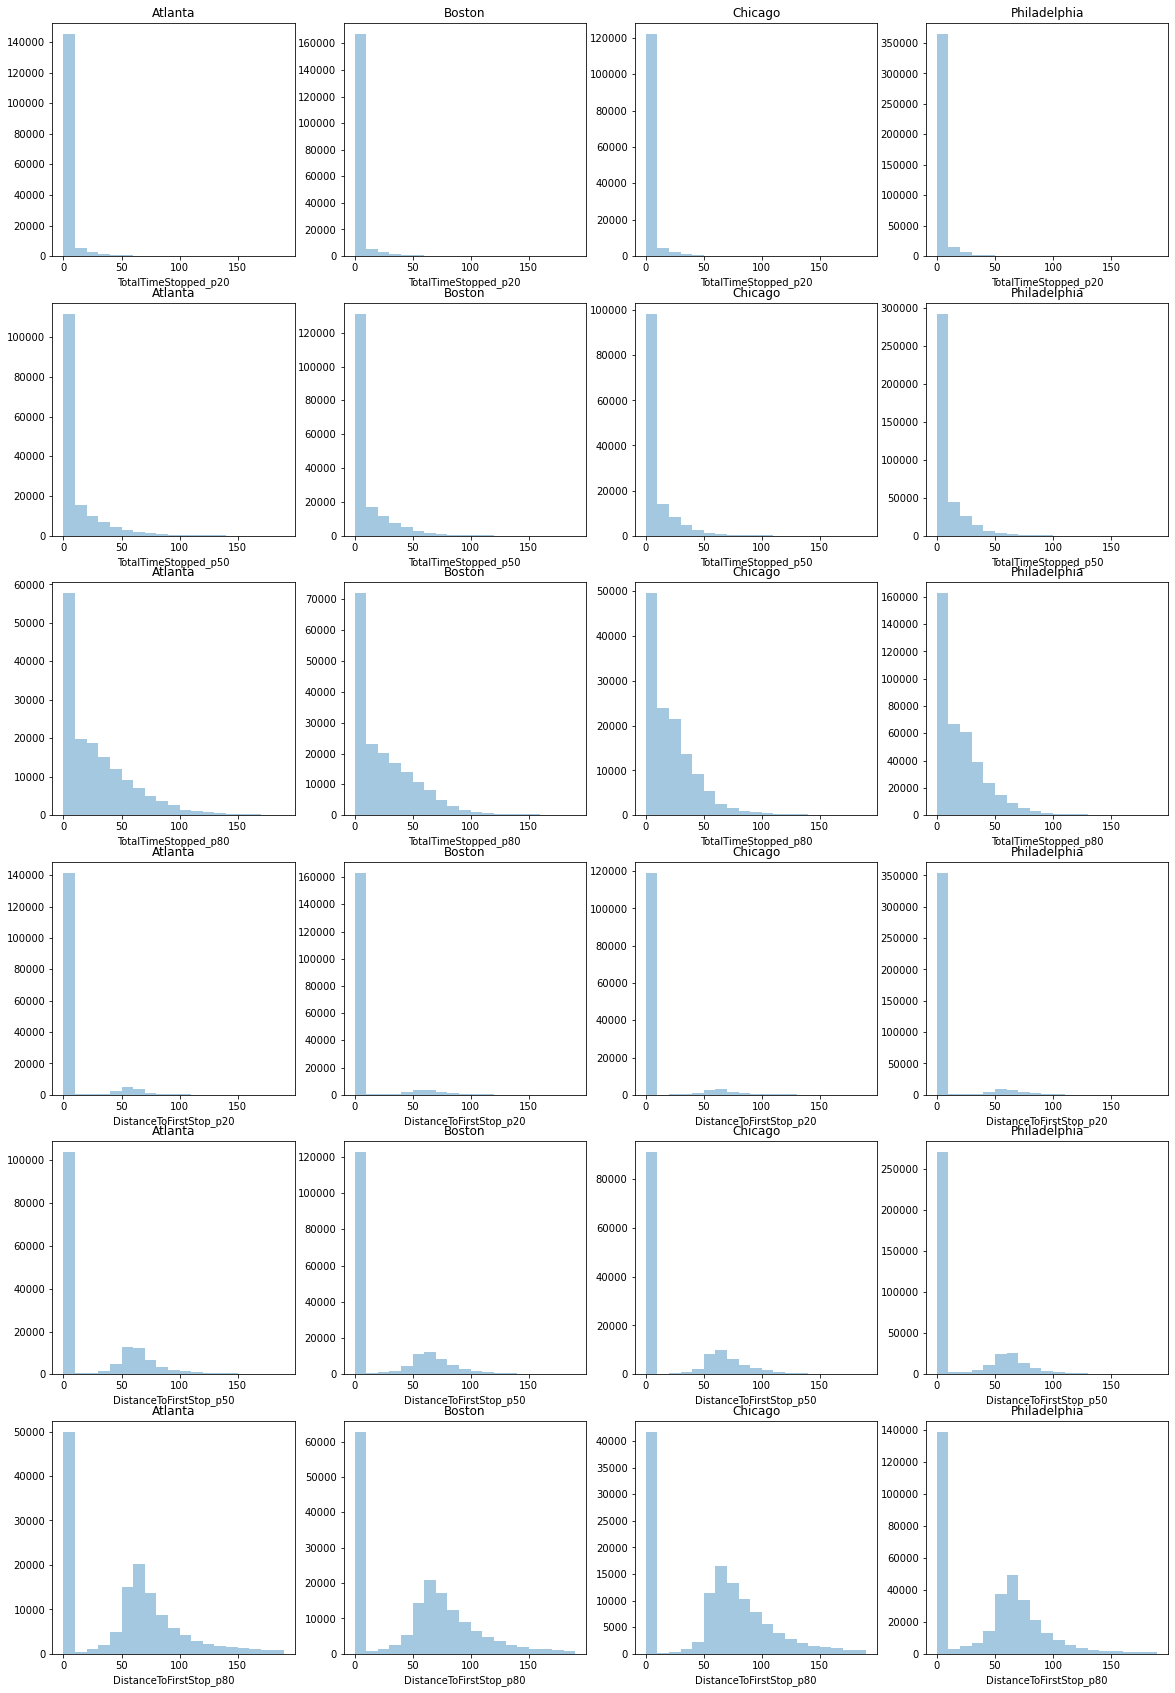

In [79]:
target_vars = ['TotalTimeStopped_p20', 'TotalTimeStopped_p50', 
               'TotalTimeStopped_p80', 'DistanceToFirstStop_p20', 
               'DistanceToFirstStop_p50', 'DistanceToFirstStop_p80']
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20,30))
cities = train.City.unique()
bins = list(range(0, 200, 10))
for i, var in enumerate(target_vars):
    for j, city in enumerate(cities):
        sns.distplot(train[train.City == city][var], bins=bins, kde=False, ax=ax[i, j]).set_title(city)

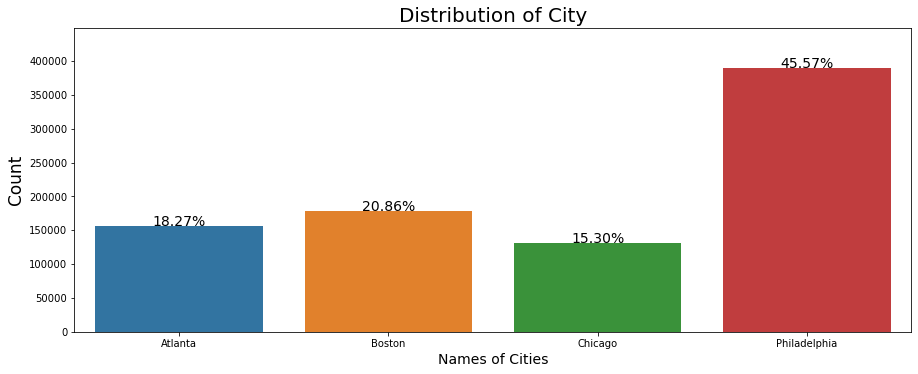

In [80]:
train_len = len(train)
plt.figure(figsize=(15,19))

plt.subplot(311)
val = sns.countplot(x="City", data=train)
val.set_title("Distribution of City", fontsize=20)
val.set_ylabel("Count",fontsize= 17)
val.set_xlabel("Names of Cities", fontsize=14)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)
    val.text(i.get_x()+i.get_width()/2., height + 3, '{:1.2f}%'.format(height/train_len*100), ha="center", fontsize=14) 
val.set_ylim(0, max(sizes) * 1.15)

plt.show()


#### From the above observation, the city Philadelphia has approximately 46% of total entires which is the highest as compared to Atlanta, Boston and Chicago.

In [81]:
hour_dist = train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()
hour_dist

,City,Hour,RowId
0,Atlanta,0,6340
1,Atlanta,1,5544
2,Atlanta,2,4542
3,Atlanta,3,3791
4,Atlanta,4,2890
...,...,...,...
91,Philadelphia,19,18538
92,Philadelphia,20,18499
93,Philadelphia,21,18834
94,Philadelphia,22,18512


#### Hourly Distribution

(0.0, 23036.8)

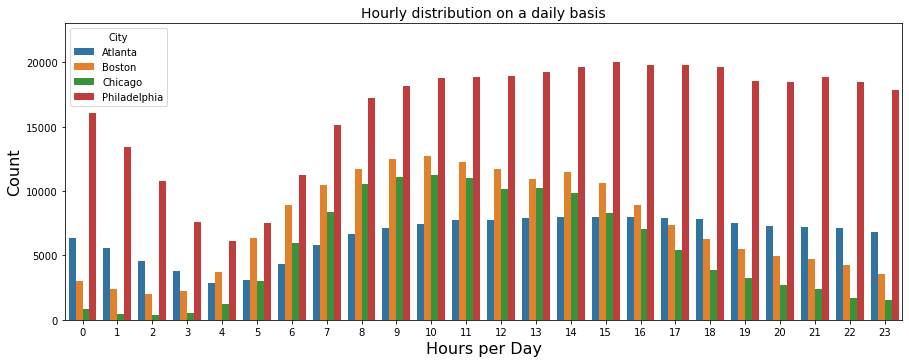

In [82]:
plt.figure(figsize=(15,12))

plt.subplot(211)
val = sns.countplot(x="Hour", data=train, hue='City', dodge=True)
val.set_title("Hourly distribution on a daily basis", fontsize=14)
val.set_ylabel("Count",fontsize= 16)
val.set_xlabel("Hours per Day", fontsize=16)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)

val.set_ylim(0, max(sizes) * 1.15)

- Observation shows that high variations on hours of entry. 
- Meanwhile Atlanta shows less entires on the daily report shown above. From 9:00am to 18:00 there is an increase with the number of entires but stil less compared to other cities.

(0.0, 70335.15)

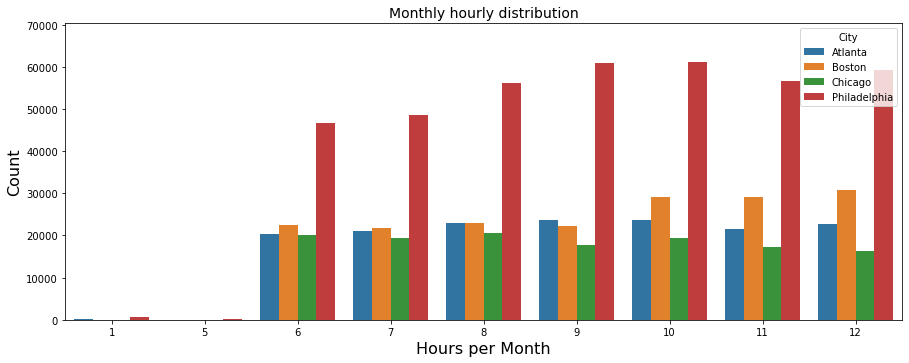

In [83]:
plt.figure(figsize=(15,12))

plt.subplot(211)
val = sns.countplot(x="Month", data=train, hue='City', dodge=True)
val.set_title("Monthly hourly distribution", fontsize=14)
val.set_ylabel("Count",fontsize= 16)
val.set_xlabel("Hours per Month", fontsize=16)
sizes=[]
for i in val.patches:
    height = i.get_height()
    sizes.append(height)

val.set_ylim(0, max(sizes) * 1.15)

- Seen from the above distribution dataset has most enties from the sixth month(June) up to December.

In [84]:
train[['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
          'TotalTimeStopped_p60','TotalTimeStopped_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalTimeStopped_p20,856387.0,1.755596,7.146549,0.0,0.0,0.0,0.0,298.0
TotalTimeStopped_p40,856387.0,5.403592,12.981674,0.0,0.0,0.0,0.0,375.0
TotalTimeStopped_p50,856387.0,7.722655,15.685910,0.0,0.0,0.0,10.0,375.0
TotalTimeStopped_p60,856387.0,11.925195,19.761325,0.0,0.0,0.0,18.0,377.0
TotalTimeStopped_p80,856387.0,22.948621,28.274091,0.0,0.0,16.0,34.0,763.0


In [85]:
# Descriptive statistics of the "•Distance to first stop" 
train[['DistanceToFirstStop_p20','DistanceToFirstStop_p40', 'DistanceToFirstStop_p50','DistanceToFirstStop_p60',
 'DistanceToFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
DistanceToFirstStop_p20,856387.0,6.765856,29.535968,0.0,0.0,0.0,0.00,1901.9
DistanceToFirstStop_p40,856387.0,20.285128,59.202108,0.0,0.0,0.0,0.00,2844.4
DistanceToFirstStop_p50,856387.0,28.837113,75.217343,0.0,0.0,0.0,53.10,2851.1
DistanceToFirstStop_p60,856387.0,44.272310,102.032250,0.0,0.0,0.0,64.20,3282.4
DistanceToFirstStop_p80,856387.0,83.991313,160.709797,0.0,0.0,60.4,85.95,4079.2


Averagly the distance from the first stop until the vehicle passes through the intersection for 80the perctile of the cars is 60 'meters'

In [86]:
# City based on 50 & 80 percentile on an average per city
train.groupby('City').agg({'TotalTimeStopped_p50':'mean','TimeFromFirstStop_p50':'mean','DistanceToFirstStop_p50':'mean','TotalTimeStopped_p80':'mean','TimeFromFirstStop_p80':'mean','DistanceToFirstStop_p80':'mean'})

,TotalTimeStopped_p50,TimeFromFirstStop_p50,DistanceToFirstStop_p50,TotalTimeStopped_p80,TimeFromFirstStop_p80,DistanceToFirstStop_p80
City,,,,,,
Atlanta,9.736069,15.231519,30.860906,28.911256,41.621201,105.185034
Boston,8.603812,13.225124,23.460217,25.922292,35.435076,62.671911
Chicago,7.141947,11.433159,24.727496,21.380041,31.045220,69.869600
Philadelphia,6.706976,11.918583,31.866747,19.723289,31.721877,89.993218


<AxesSubplot:>

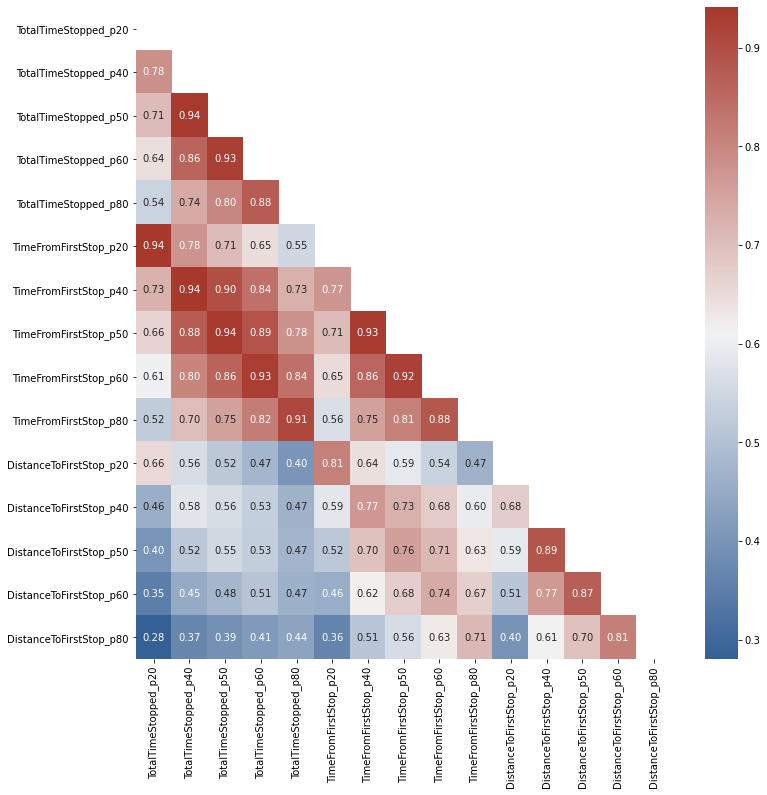

In [87]:
corr = train.iloc[:,12:-1].corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
cmap = sns.diverging_palette(250,15,s=75,l=40, n=9, center='light', as_cmap=True)
fig = plt.figure(figsize=(12,12))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f')

From the above observation, there is a high correlation between Total Time, Time from First Stop and Distance from First stop

## Data Preprocessing

In [88]:
train.isna().sum()

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [89]:
test[['EntryStreetName','ExitStreetName']].isna().sum() / test.shape[0] 

EntryStreetName    0.009992
ExitStreetName     0.008112
dtype: float64

In [90]:
train[(train['IntersectionId']==1696) & (train['City']=='Philadelphia')].groupby(['EntryStreetName','ExitStreetName','EntryHeading','ExitHeading','Path'], dropna=False).size()

EntryStreetName     ExitStreetName      EntryHeading  ExitHeading  Path                                     
South Broad Street  South Broad Street  N             N            South Broad Street_N_South Broad Street_N    101
                                        S             S            South Broad Street_S_South Broad Street_S    111
NaN                 South Broad Street  E             N            Unknown_E_South Broad Street_N                17
                                                      S            Unknown_E_South Broad Street_S                36
dtype: int64

In [91]:
# Inspect he data to see the different entries and exits
train[(train['IntersectionId']==0) & (train['City']=='Boston')][['EntryStreetName','ExitStreetName','EntryHeading','ExitHeading','Path']].value_counts()

EntryStreetName     ExitStreetName      EntryHeading  ExitHeading  Path                                  
Talbot Avenue       Talbot Avenue       W             W            Talbot Avenue_W_Talbot Avenue_W           33
New England Avenue  Norwell Street      NE            N            New England Avenue_NE_Norwell Street_N    22
Talbot Avenue       Talbot Avenue       E             E            Talbot Avenue_E_Talbot Avenue_E           21
Norwell Street      New England Avenue  S             SW           Norwell Street_S_New England Avenue_SW    11
New England Avenue  Talbot Avenue       NE            W            New England Avenue_NE_Talbot Avenue_W      6
Talbot Avenue       New England Avenue  E             SW           Talbot Avenue_E_New England Avenue_SW      3
Norwell Street      Talbot Avenue       S             W            Norwell Street_S_Talbot Avenue_W           2
Talbot Avenue       Norwell Street      E             NW           Talbot Avenue_E_Norwell Street_NW          

In [92]:
new_df = train[['City','EntryStreetName','IntersectionId']].drop_duplicates()
print("Total of Avenues :", new_df['EntryStreetName'].str.contains('Avenue').sum())
print("Total of Streets :", new_df['EntryStreetName'].str.contains('Street').sum())
print("Total of Boulevards :", new_df['EntryStreetName'].str.contains('Boulevard').sum())
print("Total of Roads:", new_df['EntryStreetName'].str.contains('Road').sum())
print("Total of Highways :", new_df['EntryStreetName'].str.contains('Highway').sum())
print("Total of Drives :", new_df['EntryStreetName'].str.contains('Drive').sum())
print("Total of Parkways :", new_df['EntryStreetName'].str.contains('Parkway').sum())

Total of Avenues : 2420
Total of Streets : 4451
Total of Boulevards : 471
Total of Roads: 427
Total of Highways : 27
Total of Drives : 347
Total of Parkways : 91


In [93]:
print (train['EntryHeading'].unique())
print (train['ExitHeading'].unique())

['NW' 'SE' 'NE' 'SW' 'E' 'W' 'N' 'S']
['NW' 'SE' 'NE' 'SW' 'W' 'E' 'N' 'S']


## Feature Engineering

Given this is a traffic analysis, there would be need to investigate the possibility of streets(size) being a major cause of traffic congestions.

In [94]:
street_code = ['Avenue','Street','Boulevard','Road','Highway','Drive','Parkway','Square','Way','Ave','St','Pkwy','Lane','Circle','Place','Other']
street_name = ['Avenue','Street','Boulevard','Road','Highway','Drive','Parkway','Square','Way','Avenue','Street','Parkway','Lane','Circle','Place','Other']

for i in range(len(street_code)):
    train.loc[~(train['EntryStreetName'].isna()) & (train['EntryStreetName'].str.contains(street_code[i])), 'EntryStreetType'] = street_name[i]
    train.loc[~(train['ExitStreetName'].isna()) & (train['ExitStreetName'].str.contains(street_code[i])), 'ExitStreetType'] = street_name[i]
    test.loc[~(test['EntryStreetName'].isna()) & (test['EntryStreetName'].str.contains(street_code[i])), 'EntryStreetType'] = street_name[i]
    test.loc[~(test['ExitStreetName'].isna()) & (test['ExitStreetName'].str.contains(street_code[i])), 'ExitStreetType'] = street_name[i]
    
    train['EntryStreetType'].fillna('Other',inplace=True)
    train['ExitStreetType'].fillna('Other',inplace=True)

    test['EntryStreetType'].fillna('Other',inplace=True)
    test['ExitStreetType'].fillna('Other',inplace=True)

In [95]:
entry_point = train[['City','IntersectionId','EntryHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'EntryHeading':'count'}).reset_index().rename(columns={'EntryHeading':'EntryCount'})
exit_point = train[['City','IntersectionId','ExitHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'ExitHeading':'count'}).reset_index().rename(columns={'ExitHeading':'ExitCount'})

#combined Entries & Exits per intersection
train = train.merge(entry_point, on=['City','IntersectionId'], how='left')
train = train.merge(exit_point, on=['City','IntersectionId'], how='left')
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2


In [96]:
entry_point_test = test[['City','IntersectionId','EntryHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'EntryHeading':'count'}).reset_index().rename(columns={'EntryHeading':'EntryCount'})
exit_point_test = test[['City','IntersectionId','ExitHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'ExitHeading':'count'}).reset_index().rename(columns={'ExitHeading':'ExitCount'})
test = test.merge(entry_point_test, on=['City','IntersectionId'], how='left')
test = test.merge(exit_point_test, on=['City','IntersectionId'], how='left')
test.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount
0,0,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,0,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta,Street,Street,3,3
1,1,1,33.75094,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,Atlanta,Street,Street,3,3
2,2,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta,Street,Street,3,3
3,3,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta,Street,Street,3,3
4,4,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta,Street,Street,3,3


In [97]:
# Map turns with integer values
cardinal_dir = {'N':1,'NE':2,'E':3,'SE':4,'S':5, 'SW':6, 'W':7, 'NW': 8}
train['EntryHeading'] = train['EntryHeading'].map(cardinal_dir)
train['ExitHeading'] = train['ExitHeading'].map(cardinal_dir)
test['EntryHeading'] = test['EntryHeading'].map(cardinal_dir)
test['ExitHeading'] = test['ExitHeading'].map(cardinal_dir)

In [98]:
train['TurnType'] = train['ExitHeading'] - train['EntryHeading']
test['TurnType'] = test['ExitHeading'] - test['EntryHeading']
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,0,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,0,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,1,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,1,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,2,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0


In [99]:
def calc_dist(row):
    radius = 6373.0
    la1 = row['SentrumLatitude']
    lo1 = row['SentrumLongitude']
    la2 = row['Latitude']
    lo2 = row['Longitude']
    span = DistanceMetric.get_metric('haversine')
    values = [[np.radians(la1), np.radians(lo1)], [np.radians(la2), np.radians(lo2)]]
    dist = np.abs(np.array(radius * span.pairwise(values)).item(1))
    return dist

In [100]:
diff_cities = ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']
sentrum_lat = [33.753746, 42.361145,41.881832,39.952583]
sentrum_lon = [-84.386330,-71.057083,-87.623177,-75.165222]

for i in range(len(diff_cities)):
    train.loc[train['City']==cities[i], 'SentrumLatitude'] = sentrum_lat[i]
    train.loc[train['City']==cities[i], 'SentrumLongitude'] = sentrum_lon[i]
    test.loc[test['City']==cities[i], 'SentrumLatitude'] = sentrum_lat[i]
    test.loc[test['City']==cities[i], 'SentrumLongitude'] = sentrum_lon[i]
# add to train and test df
train['SentrumDist'] = train.apply(calc_dist, axis=1)
test['SentrumDist'] = test.apply(calc_dist, axis=1)
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType,SentrumLatitude,SentrumLongitude,SentrumDist
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,0,0,...,0.0,Atlanta,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,0,0,...,0.0,Atlanta,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,1,0,...,0.0,Atlanta,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,1,0,...,0.0,Atlanta,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,2,0,...,0.0,Atlanta,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422


Changes in weather can have an effect on traffic congestions.

In [102]:
tempreature_data = [['Chicago',-4.6,-2.4,3.2,9.4,15.1,20.5,23.3,22.4,18.1,11.4,4.6,-2.3],
['Boston',-1.5,0,3,9,14.5,19.5,23,22,18,12,7,1.5],
['Atlanta',6.6,8.7,12.6,16.8,21.4,25.3,26.8,26.3,23.2,17.6,12.5,7.7],
['Philadelphia',0.5,2.1,6.4,12.2,17.7,23,25.6,24.8,20.6,14.2,8.6,3]]


In [103]:
rain_data = [['Chicago',45,45,65,85,95,90,95,125,80,80,80,55],
['Boston',85,85,110,95,90,95,85,85,85,100,100,95],
['Atlanta',105,120,120,85,95,100,135,100,115,85,105,100],
['Philadelphia',75,65,95,90,95,85,110,90,95,80,75,90]]


The above data on average rain and tempreture for a year in the above cities in US where obtained from [Climates to travel](https://www.climatestotravel.com/)

In [104]:
col = ['City'] + np.linspace(1,12,12,dtype=int).tolist()
col

['City', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [106]:
temp_data = pd.DataFrame(tempreature_data, columns = col).set_index('City').unstack().reset_index()
temp_data.columns = ['Month','City','Temperature']

data_rain_df = pd.DataFrame(rain_data, columns = col).set_index('City').unstack().reset_index()
data_rain_df.columns = ['Month','City','Rainfall']

train = train.merge(temp_data, on=['Month','City'])
train = train.merge(data_rain_df, on=['Month','City'])

test = test.merge(temp_data, on=['Month','City'])
test = test.merge(data_rain_df, on=['Month','City'])
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType,SentrumLatitude,SentrumLongitude,SentrumDist,Temperature,Rainfall
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,0,0,...,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422,25.3,100
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,0,0,...,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422,25.3,100
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,1,0,...,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422,25.3,100
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,1,0,...,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422,25.3,100
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,2,0,...,Boulevard,Boulevard,3,2,0,33.753746,-84.38633,5.840422,25.3,100


Convert categorical variabes to numerical values before feeding into a model

In [113]:
ATTR = ['Hour', 'Weekend','EntryStreetType', 'ExitStreetType', 'EntryCount', 'ExitCount','TurnType', 'SentrumDist','Temperature','Rainfall','City']

new_train = train[ATTR]
new_test = test[ATTR]


In [114]:
city_label = LabelEncoder().fit(cities)
new_train.loc[:,'City'] = city_label.transform(new_train['City'])
new_test.loc[:,'City'] = city_label.transform(new_test['City'])

In [116]:
# encode streettype
StreetType = np.unique(new_train['EntryStreetType'].unique().tolist() + new_test['ExitStreetType'].unique().tolist()) 
street_label = LabelEncoder().fit(StreetType)
new_train.loc[:,'EntryStreetType'] = street_label.transform(new_train['EntryStreetType'])
new_train.loc[:,'ExitStreetType'] = street_label.transform(new_train['ExitStreetType'])
new_test.loc[:,'EntryStreetType'] = street_label.transform(new_test['EntryStreetType'])
new_test.loc[:,'ExitStreetType'] = street_label.transform(new_test['ExitStreetType'])

In [117]:
new_train.head()

,Hour,Weekend,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType,SentrumDist,Temperature,Rainfall,City
0,0,0,1,1,3,2,0,5.840422,25.3,100,0
1,0,0,1,1,3,2,0,5.840422,25.3,100,0
2,1,0,1,1,3,2,0,5.840422,25.3,100,0
3,1,0,1,1,3,2,0,5.840422,25.3,100,0
4,2,0,1,1,3,2,0,5.840422,25.3,100,0


In [119]:
#Standardize our dataset
scaler = StandardScaler().fit(new_train)
df_train_scaled = scaler.transform(new_train)
df_test_scaled = scaler.transform(new_test)
df_train_scaled

array([[-2.04735894, -0.620332  , -0.99630629, ...,  1.09677741,
         0.53505405, -1.60110713],
       [-2.04735894, -0.620332  , -0.99630629, ...,  1.09677741,
         0.53505405, -1.60110713],
       [-1.88266419, -0.620332  , -0.99630629, ...,  1.09677741,
         0.53505405, -1.60110713],
       ...,
       [ 1.08184131,  1.61204   ,  0.96985772, ..., -1.62105345,
        -0.18491926,  0.95160208],
       [ 1.24653606,  1.61204   ,  0.96985772, ..., -1.62105345,
        -0.18491926,  0.95160208],
       [ 1.74062031,  1.61204   ,  0.96985772, ..., -1.62105345,
        -0.18491926,  0.95160208]])